### Load model/ Label map

In [1]:
import sys
from pathlib import Path

# sửa path này đúng với máy bạn
PROJECT_ROOT = Path("/home/dangkhoi/dev/Projects/WorldLevel_DIP").resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Added to sys.path:", PROJECT_ROOT)
print("sys.path[0]:", sys.path[0])


Added to sys.path: /home/dangkhoi/dev/Projects/WorldLevel_DIP
sys.path[0]: /home/dangkhoi/dev/Projects/WorldLevel_DIP


In [2]:
import torch
import numpy as np
import cv2
import mediapipe as mp
from collections import deque
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from src.model import GRUClassifier
from src.dataset import WLASLKeypointDataset
from src.train_utils import eval_one_epoch


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Load dataset metadata =====
tmp_ds = WLASLKeypointDataset(train=False)
num_classes = tmp_ds.num_classes
label_map = tmp_ds.label_map
idx2label = {v: k for k, v in label_map.items()}

print("Num classes:", num_classes)


[Dataset] Loaded 296 samples
[Dataset] Num classes = 27
Num classes: 27


In [4]:
# ===== Load model =====
model = GRUClassifier(
    input_size=63,
    hidden_size=128,
    num_layers=1,
    num_classes=num_classes,
    dropout=0.3
).to(device)

ckpt = torch.load("best_gru_wlasl1hand.pt", map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

print("✅ Model loaded (best checkpoint)")


✅ Model loaded (best checkpoint)


/tmp/ipykernel_110364/1991908023.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("best_gru_wlasl1hand.pt", map_location=device)


### Top 1 - Top 5

In [5]:
import torch
from torch.utils.data import DataLoader, Subset
from src.dataset import WLASLKeypointDataset

BATCH_SIZE = 8
WINDOW = 32

# 1) dataset: train có augment, eval không augment
train_ds = WLASLKeypointDataset(train=True, target_len=WINDOW)
eval_ds  = WLASLKeypointDataset(train=False, target_len=WINDOW)

# đảm bảo cùng danh sách samples
assert len(train_ds.samples) == len(eval_ds.samples), "Train/Eval dataset phải cùng sample list"

# 2) split index cố định
total_count = len(train_ds)
g = torch.Generator().manual_seed(42)
perm = torch.randperm(total_count, generator=g).tolist()

train_size = int(0.7 * total_count)
val_size   = int(0.15 * total_count)
test_size  = total_count - train_size - val_size

train_idx = perm[:train_size]
val_idx   = perm[train_size:train_size + val_size]
test_idx  = perm[train_size + val_size:]

# 3) subset: train dùng train_ds, val/test dùng eval_ds
train_subset = Subset(train_ds, train_idx)
val_subset   = Subset(eval_ds,  val_idx)
test_subset  = Subset(eval_ds,  test_idx)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_subset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_subset,  batch_size=BATCH_SIZE, shuffle=False)

print("Loaders ready:")
print("Train:", len(train_subset), "Val:", len(val_subset), "Test:", len(test_subset))


[Dataset] Loaded 296 samples
[Dataset] Num classes = 27
[Dataset] Loaded 296 samples
[Dataset] Num classes = 27
Loaders ready:
Train: 207 Val: 44 Test: 45


In [6]:
def evaluate_topk(model, loader, k=5):
    model.eval()
    correct1, correctk, total = 0, 0, 0

    with torch.no_grad():
        for seq, labels in loader:
            seq = seq.to(device)
            labels = labels.to(device)

            logits = model(seq)
            _, pred1 = logits.max(1)

            correct1 += (pred1 == labels).sum().item()

            topk = logits.topk(k, dim=1).indices
            correctk += sum([labels[i] in topk[i] for i in range(labels.size(0))])

            total += labels.size(0)

    return correct1 / total, correctk / total


In [7]:
top1, top5 = evaluate_topk(model, val_loader, k=5)
print(f"Top-1 accuracy: {top1:.4f}")
print(f"Top-5 accuracy: {top5:.4f}")


Top-1 accuracy: 0.2273
Top-5 accuracy: 0.6364


### Confusion matrix

In [8]:
y_true, y_pred = [], []

with torch.no_grad():
    for seq, labels in val_loader:
        seq = seq.to(device)
        logits = model(seq)
        preds = logits.argmax(dim=1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(labels.numpy())


/home/dangkhoi/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")


<Figure size 1200x1200 with 0 Axes>

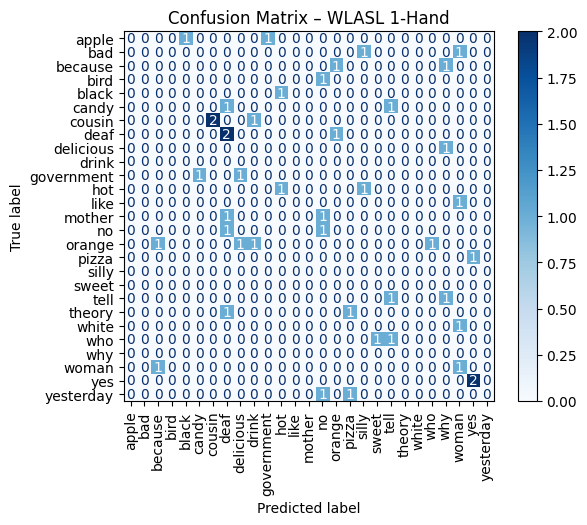

In [9]:
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
disp = ConfusionMatrixDisplay(cm, display_labels=[idx2label[i] for i in range(num_classes)])

plt.figure(figsize=(12, 12))
disp.plot(xticks_rotation=90, cmap="Blues", values_format="d")
plt.title("Confusion Matrix – WLASL 1-Hand")
plt.show()


### Demo


In [10]:
def extract_keypoints(hand_landmarks):
    pts = []
    for lm in hand_landmarks.landmark:
        pts.extend([lm.x, lm.y, lm.z])
    return np.array(pts, dtype=np.float32)


In [11]:
# print("buffer len:", len(buffer))

# if len(buffer) == WINDOW:
#     print(np.std(np.array(buffer)))


In [12]:
print(logits.softmax(dim=1)[0][:5])


tensor([0.0362, 0.0034, 0.0968, 0.0349, 0.0056], device='cuda:0')


In [13]:
import cv2
import numpy as np
import torch
import mediapipe as mp
from collections import deque

# ================= CONFIG =================
VIDEO_PATH = "/home/dangkhoi/dev/Projects/WorldLevel_DIP/data_raw/no/38527.mp4"
WINDOW = 16
ALPHA = 0.6
CONF_THRESHOLD = 0.1
TOPK = 3
LOOP_VIDEO = True
# =========================================

# ===== MediaPipe Hands =====
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

def extract_keypoints(hand_landmarks):
    pts = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark])
    pts = pts - pts[0]                    # wrist làm gốc
    pts = pts / (np.linalg.norm(pts) + 1e-6)
    return pts.flatten().astype(np.float32)


# ===== Video =====
cap = cv2.VideoCapture(VIDEO_PATH)

# FPS control (rất quan trọng)
fps = cap.get(cv2.CAP_PROP_FPS)
if fps <= 0:
    fps = 25
delay = int(1000 / fps)
print(f"Video FPS = {fps:.2f} | delay = {delay} ms")

# ===== Buffer & EMA =====
buffer = deque(maxlen=WINDOW)
ema_logits = None

topk_labels = ["...", "...", "..."]
topk_confs = [0.0, 0.0, 0.0]

print("▶ Demo running... (ESC to quit)")

while True:
    ret, frame = cap.read()

    # ===== Hết video → loop =====
    if not ret:
        if LOOP_VIDEO:
            cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
            buffer.clear()
            ema_logits = None
            continue
        else:
            break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    res = hands.process(rgb)

    if res.multi_hand_landmarks:
        kp = extract_keypoints(res.multi_hand_landmarks[0])
        buffer.append(kp)

        if len(buffer) == WINDOW:
            seq = torch.tensor(
                np.array(buffer),
                dtype=torch.float32,
                device=device
            ).unsqueeze(0)

            with torch.no_grad():
                logits = model(seq)

                # ===== EMA smoothing =====
                ema_logits = logits if ema_logits is None else \
                             (ALPHA * ema_logits + (1 - ALPHA) * logits)

                probs = ema_logits.softmax(dim=1)[0]

                # ===== Top-K =====
                topk = torch.topk(probs, TOPK)
                topk_indices = topk.indices.tolist()
                topk_values = topk.values.tolist()

                topk_labels = [idx2label[i] for i in topk_indices]
                topk_confs = topk_values

                # ===== Confidence threshold =====
                if topk_confs[0] < CONF_THRESHOLD:
                    topk_labels = ["...", "...", "..."]

    else:
        # Mất tay → reset để tránh “ám”
        buffer.clear()
        ema_logits = None
        topk_labels = ["...", "...", "..."]
        topk_confs = [0.0, 0.0, 0.0]
        pass

    # ===== Overlay =====
    y0 = 50
    for i in range(TOPK):
        cv2.putText(
            frame,
            f"{i+1}. {topk_labels[i]} ({topk_confs[i]:.2f})",
            (30, y0 + i * 35),
            cv2.FONT_HERSHEY_SIMPLEX,
            1.0,
            (0, 255, 0),
            2
        )

    cv2.putText(
        frame,
        f"buffer: {len(buffer)}/{WINDOW}",
        (30, y0 + TOPK * 35 + 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,
        (0, 255, 0),
        2
    )

    cv2.imshow("WLASL 1-Hand Demo | Top-3", frame)

    key = cv2.waitKey(delay) & 0xFF
    if key == 27:  # ESC
        break

cap.release()
hands.close()
cv2.destroyAllWindows()
print("■ Demo finished.")


Video FPS = 29.97 | delay = 33 ms
▶ Demo running... (ESC to quit)


I0000 00:00:1766244390.067880  110364 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1766244390.072426  110538 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 25.0.7-0ubuntu0.24.04.2), renderer: AMD Radeon 780M (radeonsi, phoenix, LLVM 20.1.2, DRM 3.61, 6.14.0-37-generic)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1766244390.100036  110512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766244390.116748  110527 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/dangkhoi/miniconda3/envs/env1/lib/python3.11/site-packages/cv2/qt/plugins"
W0000 00:00:1766244390.381216  110517 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSION

■ Demo finished.


In [14]:
print(probs.topk(10))


torch.return_types.topk(
values=tensor([0.1918, 0.1800, 0.1537, 0.1094, 0.1051, 0.0634, 0.0519, 0.0206, 0.0159,
        0.0140], device='cuda:0'),
indices=tensor([25,  3, 17, 26, 16, 14,  0,  8, 20, 22], device='cuda:0'))


In [15]:
seq = seq[:, torch.randperm(WINDOW)]


In [16]:
import torch

p = torch.tensor([0.1456, 0.1351, 0.1230, 0.1209, 0.0990])
entropy = -(p * torch.log(p)).sum()
print(entropy.item())


1.29313325881958
